In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
import torchvision.models as models
from os.path import exists

In [2]:
# Check if GPU is available
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load and preprocess data
training = pd.read_csv('training.csv')
testing = pd.read_csv('test.csv')

y_train = training.iloc[:, :30]

# Get the last feature column
lastFeature = training.iloc[:, -1]

# Split the last feature by spaces
splitFeatures = lastFeature.str.split(' ', expand=True)

# Drop the original last feature and concatenate the new split features
training = pd.concat([training.drop(training.columns[-1], axis=1), splitFeatures], axis=1)
testing = pd.concat([testing.drop(testing.columns[-1], axis=1), splitFeatures], axis=1)

# Drop the first columns here so they aren't mislabeled, and this way we can just make this the X_train
training.drop(training.columns[range(0, 30)], axis=1, inplace=True)

# Rename the columns to pixel_i
training.columns = [f'pixel_{i}' for i in range(training.shape[1])]
testing.columns = [f'pixel_{i}' for i in range(testing.shape[1])]

# There was an extra column that was just the index
testing.drop(columns=testing.columns[[0]], inplace=True)

# Rename the columns to pixel_i
testing.columns = ['ImageId'] + [f'pixel_{i}' for i in range(1, testing.shape[1])]

X_train = training
X_test = testing

# Reshape dataframe into numpy array so I can reshape it again
X_train = X_train.to_numpy(dtype=np.float32)

# Reshape image data so the model can process it as a Tensor
X_train = X_train.reshape(-1, 1, 96, 96)
X_train = X_train / 255.0

# Reshape y_train into a numpy array as well
y_train_copy = y_train.copy()
y_train_copy = y_train_copy.notna().astype(np.float32)
y_train_copy = y_train_copy.to_numpy(dtype=np.int32)

# Fill in missing values with the previous row
y_train.fillna(method="ffill", inplace=True)
# Fill in missing values with the next row
y_train.fillna(method="bfill", inplace=True)
y_train = np.array(y_train, dtype=np.float32)

# Reshape test data
X_test = X_test.to_numpy(dtype=np.float32)
X_test = X_test.reshape(-1, 1, 96, 96)
X_test = X_test / 255.0


C:\Users\jespy\AppData\Local\Temp\ipykernel_3512\3011135401.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train.fillna(method="ffill", inplace=True)
C:\Users\jespy\AppData\Local\Temp\ipykernel_3512\3011135401.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train.fillna(method="bfill", inplace=True)


In [4]:
# pretrained resnet model - Kaggle score: 5.16140 Private, 5.23844 Public

# Load a pretrained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1-channel (grayscale) images
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer to output 30 keypoints
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 30)

# Move the model to the appropriate device
model = resnet.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

# Convert data to PyTorch tensors and create DataLoader
xTrainTensor = torch.tensor(X_train, dtype=torch.float32)
yTrainTensor = torch.tensor(y_train, dtype=torch.float32)
trainDataset = TensorDataset(xTrainTensor, yTrainTensor)
trainLoader = DataLoader(trainDataset, batch_size=24, shuffle=True)


if exists('models/resnet.pth'):
    resnet.load_state_dict(torch.load('models/resnet.pth'))
else:
    # Train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        resnet.train()
        running_loss = 0.0
        for inputs, targets in trainLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = resnet(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainLoader)}')

    # Save the trained model
    torch.save(resnet.state_dict(), 'models/resnet.pth')

C:\Users\jespy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jespy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\jespy\AppData\Local\Temp\ipykernel_16560\307942502.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the 

In [3]:
# More complex CNN - Kaggle Score: 4.56319 Private, 4.73469 Public

class ImprovedCnnModel(nn.Module):
    def __init__(self):
        super(ImprovedCnnModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Adjusted for 96x96 input
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 30)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors and create DataLoader
xTrainTensor = torch.tensor(X_train.reshape(-1, 1, 96, 96), dtype=torch.float32)
yTrainTensor = torch.tensor(y_train, dtype=torch.float32)
trainDataset = TensorDataset(xTrainTensor, yTrainTensor)
trainLoader = DataLoader(trainDataset, batch_size=24, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCnnModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

modelPath = 'models/cnn100.pth'

if exists(modelPath):
    model.load_state_dict(torch.load(modelPath))
else:
    numEpochs = 80
    for epoch in range(numEpochs):
        model.train()
        runningLoss = 0.0
        for inputs, targets in trainLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            runningLoss += loss.item()
        
        print(f'Epoch {epoch+1}/{numEpochs}, Loss: {runningLoss/len(trainLoader)}')

    torch.save(model.state_dict(), modelPath)

C:\Users\jespy\AppData\Local\Temp\ipykernel_3512\1627864044.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelPath))


In [5]:
# Evaluation
batch_size = 32  # Adjust batch size to prevent GPU memory overflow
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 96, 96), dtype=torch.float32)
X_test_tensor = X_test_tensor.to(device)

model.eval()
y_pred = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        batch_X_test_tensor = X_test_tensor[i:i+batch_size]
        batch_y_pred_tensor = model(batch_X_test_tensor)
        y_pred.append(batch_y_pred_tensor.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

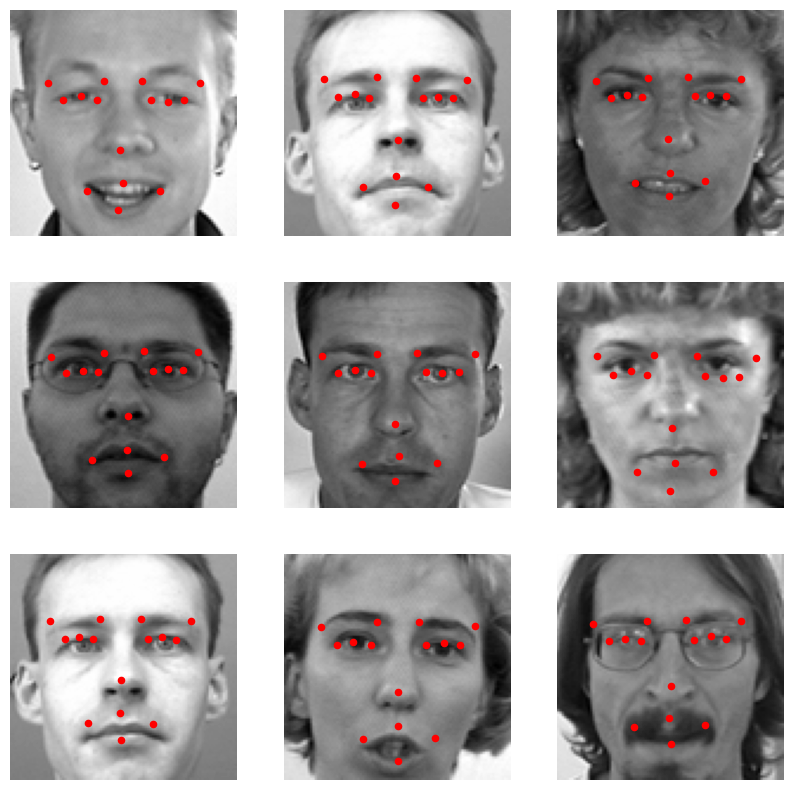

In [7]:
import matplotlib.pyplot as plt

def showPrediction(image, keypoints, size, idx): # Shows the image with the predicted keypoints
    plt.subplot(int(size ** 0.5), int(size ** 0.5), idx + 1)
    plt.imshow(image, cmap='gray')
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='red', s=20)
    plt.axis('off')

X_test = X_test.reshape(-1, 96, 96)

plt.figure(figsize=(10, 10))
for idx in range(9):
    showPrediction(X_test[idx + 40], y_pred[idx], 9, idx)
plt.show()

In [ ]:
ids = {
    "left_eye_center_x": 0,
    "left_eye_center_y": 1,
    "right_eye_center_x": 2,
    "right_eye_center_y": 3, 
    "left_eye_inner_corner_x": 4,
    "left_eye_inner_corner_y": 5,
    "left_eye_outer_corner_x": 6,
    "left_eye_outer_corner_y": 7,
    "right_eye_inner_corner_x": 8,
    "right_eye_inner_corner_y": 9,
    "right_eye_outer_corner_x": 10,
    "right_eye_outer_corner_y": 11,
    "left_eyebrow_inner_end_x": 12,
    "left_eyebrow_inner_end_y": 13,
    "left_eyebrow_outer_end_x": 14,
    "left_eyebrow_outer_end_y": 15,
    "right_eyebrow_inner_end_x": 16,
    "right_eyebrow_inner_end_y": 17,
    "right_eyebrow_outer_end_x": 18,
    "right_eyebrow_outer_end_y": 19,
    "nose_tip_x": 20,
    "nose_tip_y": 21,
    "mouth_left_corner_x": 22,
    "mouth_left_corner_y": 23,
    "mouth_right_corner_x": 24,
    "mouth_right_corner_y": 25,
    "mouth_center_top_lip_x": 26,
    "mouth_center_top_lip_y": 27,
    "mouth_center_bottom_lip_x": 28,
    "mouth_center_bottom_lip_y":29
}

idTable = pd.read_csv('IdLookupTable.csv')

submission_df = pd.DataFrame(columns=['RowId', 'Location'])

# idTable.iloc[i, 0] = row id
#              i, 1  = Image id
#              i, 2  = Feature name
#              i, 3  = Location

rows = []
for i in range(len(idTable)):
    rowId = idTable.iloc[i, 0]
    location = y_pred[idTable.iloc[i, 1] - 1][ids[idTable.iloc[i, 2]]]
    rows.append([int(rowId), location])

submission_df = pd.DataFrame(rows, columns=['RowId', 'Location'])
submission_df.to_csv('submission.csv', index=False)

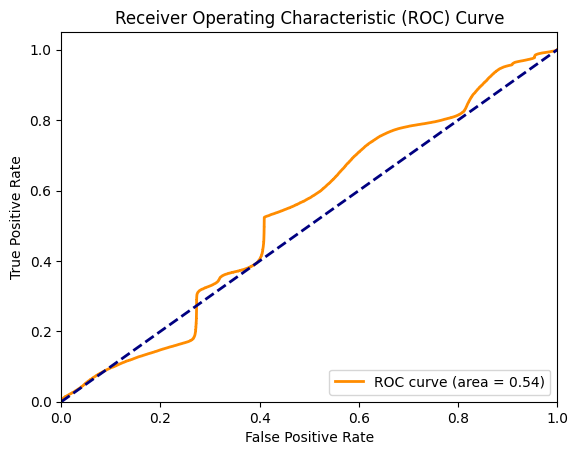

<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for ROC curve calculation
y_train_flat = y_train_copy.flatten()
y_pred_flat = y_pred.flatten()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_train_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

plt.savefig('images/roc_curve.png')

Epoch 1/100, Loss: 2377.713826497396, Accuracy: 0.0013997257294178843
Epoch 2/100, Loss: 1733.4395203882334, Accuracy: 0.02514304629498274
Epoch 3/100, Loss: 1170.9047197614398, Accuracy: 0.0742658533125266
Epoch 4/100, Loss: 735.5053632048523, Accuracy: 0.2040762283066156
Epoch 5/100, Loss: 434.46319798060824, Accuracy: 0.39566841632382843
Epoch 6/100, Loss: 252.77224191678624, Accuracy: 0.5103749940889961
Epoch 7/100, Loss: 145.81971032278878, Accuracy: 0.5870950962311439
Epoch 8/100, Loss: 87.92673554712412, Accuracy: 0.6567550952853832
Epoch 9/100, Loss: 57.30742617367076, Accuracy: 0.7243769801863148
Epoch 10/100, Loss: 45.85218618354019, Accuracy: 0.7588357686669503
Epoch 11/100, Loss: 36.750349401616724, Accuracy: 0.7982408852319478
Epoch 12/100, Loss: 34.47100237762036, Accuracy: 0.8059630207594458
Epoch 13/100, Loss: 31.67010517509616, Accuracy: 0.8205561072492552
Epoch 14/100, Loss: 28.86412780138911, Accuracy: 0.8379817468198799
Epoch 15/100, Loss: 28.545412770744896, Accura

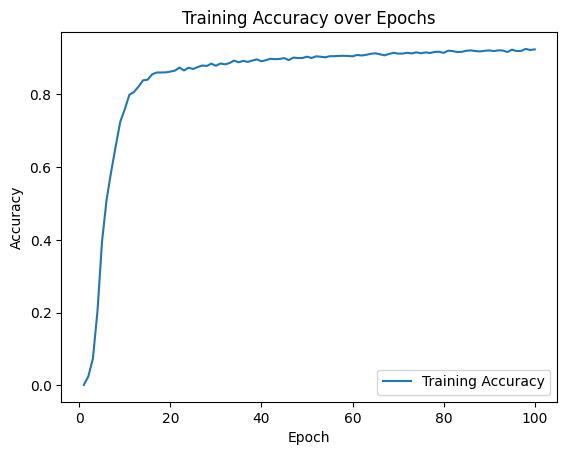

<Figure size 640x480 with 0 Axes>

In [ ]:
# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCnnModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, targets in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        predicted = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        correct_predictions += np.sum(np.isclose(predicted, targets, atol=7))  # atol = tolerance
        total_predictions += np.prod(targets.shape)
    
    epoch_loss = running_loss / len(trainLoader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Save the trained model
# torch.save(model.state_dict(), modelPath)

# Plot the accuracy over epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

# Save the accuracy plot
plt.savefig('images/training_accuracy.png')